In [ ]:
# System and utility libraries
import os
import pickle
import h5py
import scipy
import PIL
import PIL.Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Scikit-learn modules
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, plot_roc_curve, mean_squared_error,
    median_absolute_error, mean_absolute_error, auc,
    confusion_matrix, plot_confusion_matrix, classification_report
)

# Keras / TensorFlow modules
from keras.models import Sequential, Model, model_from_json
from keras.layers import (
    Dense, Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate,
    BatchNormalization, Activation, add, Conv2D, MaxPooling2D,
    Reshape, Flatten
)
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

# Custom module
from ml_models import *
from Unet_1DCNN import Unet

# Random seed for reproducibility
from numpy.random import seed


In [ ]:
# General Parameters
feature_number = 64
signal_length = X_Train.shape[1]
# Extra Parameters
num_channel = 1
model_depth = 1
model_width = 128
kernel_size = 3

In [ ]:
# Build model for PPG2BP - Shallow-Wide U-net as AutoEncoder
# D_S shoud be FALSE or '0' for the AutoEncoder Model
# D_S = 0 # Deep Supervision ON/OFF; A_E = 1 # AutoEncoder Model ON/OFF
AutoEnc_Unet = Unet(signal_length, model_depth, num_channel, model_width, kernel_size, 0, 1, feature_number,)
AutoEnc_Unet.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Data Cleansing

In [22]:
!gdown --id 1-J7JJpw0qdti8UFRQKiWUPl3AVQp9JO0
df = pd.read_excel('Dataset.xlsx')

Downloading...
From: https://drive.google.com/uc?id=1-J7JJpw0qdti8UFRQKiWUPl3AVQp9JO0
To: /content/Dataset.xlsx
100% 838k/838k [00:00<00:00, 55.5MB/s]


In [23]:
df.drop(columns= ['Ptid'],inplace= True)
df_dummy = pd.DataFrame()

In [26]:
for i in range(0,len(df.columns)):
  if(i<=7):
    X = df[df.columns[i]]
    Y = pd.get_dummies(X)
    df_dummy = pd.concat([df_dummy, Y], axis=1)
  elif(i>7):
    X = df[df.columns[i]]
    df_dummy = pd.concat([df_dummy, X], axis=1)
df_dummy.to_excel('Dataset_Dummy.xlsx', sheet_name= 'Dummy')

In [29]:
if (df_dummy.isnull().values.any() == False):
  print(f'Total NULL values in the Original DataFrame = {df_dummy.isnull().sum().sum()}')
  print(df_dummy.isnull().sum())
  for i in range(0,len(df_dummy.columns)):
    df_dummy[df_dummy.columns[i]] = df_dummy[df_dummy.columns[i]].fillna(0)

Total NULL values in the Original DataFrame = 0
Female                      0
Male                        0
African American            0
Asian                       0
Caucasian                   0
                           ..
Risk_Estrogen_Deficiency    0
Risk_Immobilization         0
Risk_Recurring_Falls        0
Count_Of_Risks              0
Persistency_Flag            0
Length: 119, dtype: int64


Upload Descriptive Plots from MS Excel Pivot Charts from Google Drive

In [42]:
# General Parameters
feature_number = 32
signal_length = X_Train.shape[1]
# Extra Parameters
num_channel = 1
model_depth = 1
model_width = 64
kernel_size = 3

In [44]:
# Build model for PPG2BP - Shallow-Wide U-net as AutoEncoder
# D_S shoud be FALSE or '0' for the AutoEncoder Model
D_S = 0 # Deep Supervision ON/OFF
A_E = 1 # AutoEncoder Model ON/OFF
AutoEnc_Unet = Unet(signal_length, D_S, A_E, model_depth, num_channel, model_width, kernel_size, feature_number)
AutoEnc_Unet.compile(optimizer='adam', loss='mse', metrics=['mae'])
AutoEnc_Unet.load_weights('/content/GDrive/MyDrive/Colab Notebooks/DG_Internship/Project Health+/Model.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=20, mode='min'),
            ModelCheckpoint('/content/GDrive/MyDrive/Colab Notebooks/DG_Internship/Project Health+/Model.h5', verbose=1, monitor='val_loss', save_best_only= True, mode= 'min')]
AutoEnc_Unet.fit(X_Train, Y_Train, epochs= 100, batch_size= 128, verbose= 1, validation_split= 0.2, shuffle= True, callbacks= callbacks)
UNETAE_Feature_Extractor = Model(inputs= AutoEnc_Unet.input, outputs= AutoEnc_Unet.get_layer('features').output)
Train_Features = UNETAE_Feature_Extractor.predict(X_Train)
Test_Features = UNETAE_Feature_Extractor.predict(X_Test)

In [43]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.8087591240875912
Precision = 0.8067722731272973
Recall = 0.7873970075086322
f1-Score = 0.8071059993341674


In [95]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[344,  87],
       [ 83, 171]])

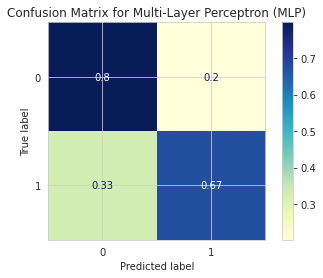

In [96]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Multi-Layer Perceptron (MLP)')
plt.show(matrix)

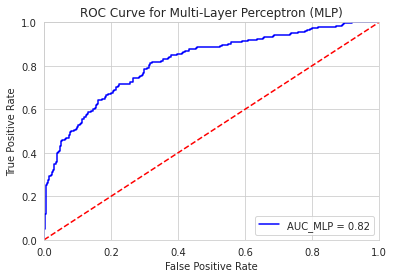

In [98]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_MLP, tpr_MLP, threshold = roc_curve(Y_Test, Probs)
roc_auc_MLP = auc(fpr_MLP, tpr_MLP)
#
plt.title('ROC Curve for Multi-Layer Perceptron (MLP)')
plt.plot(fpr_MLP, tpr_MLP, 'b', label = 'AUC_MLP = %0.2f' % roc_auc_MLP)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Combined ROC Plot(s)

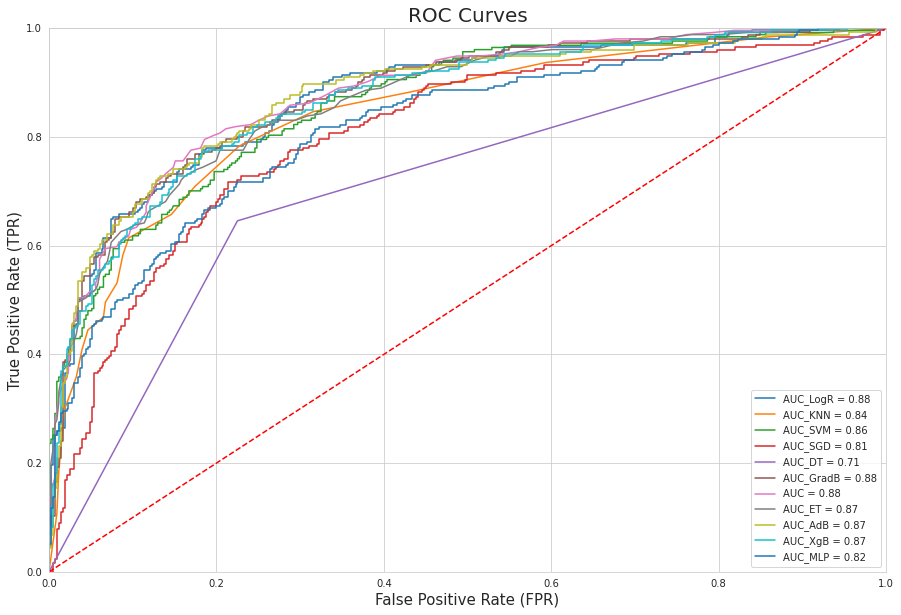

In [99]:
plt.figure(figsize = (15,10))
plt.title('ROC Curves', fontsize = 20)
plt.plot(fpr_LogR, tpr_LogR, label = 'AUC_LogR = %0.2f' % roc_auc_LogR)
plt.plot(fpr_KNN, tpr_KNN, label = 'AUC_KNN = %0.2f' % roc_auc_KNN)
plt.plot(fpr_SVM, tpr_SVM, label = 'AUC_SVM = %0.2f' % roc_auc_SVM)
plt.plot(fpr_SGD, tpr_SGD, label = 'AUC_SGD = %0.2f' % roc_auc_SGD)
plt.plot(fpr_DT, tpr_DT, label = 'AUC_DT = %0.2f' % roc_auc_DT)
plt.plot(fpr_GradB, tpr_GradB, label = 'AUC_GradB = %0.2f' % roc_auc_GradB)
plt.plot(fpr_RF, tpr_RF, label = 'AUC = %0.2f' % roc_auc_RF)
plt.plot(fpr_ET, tpr_ET, label = 'AUC_ET = %0.2f' % roc_auc_ET)
plt.plot(fpr_AdB, tpr_AdB, label = 'AUC_AdB = %0.2f' % roc_auc_AdB)
plt.plot(fpr_XgB, tpr_XgB, label = 'AUC_XgB = %0.2f' % roc_auc_XgB)
plt.plot(fpr_MLP, tpr_MLP, label = 'AUC_MLP = %0.2f' % roc_auc_MLP)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)', fontsize = 15)
plt.xlabel('False Positive Rate (FPR)', fontsize = 15)
plt.show()

##### Logistic Regression based Classifier

In [115]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error: %f" % MAE)
print("Score: %f" % Score)

Mean Absolute Error: 0.270073
Score: 0.718145


In [116]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[376,  55],
       [130, 124]])

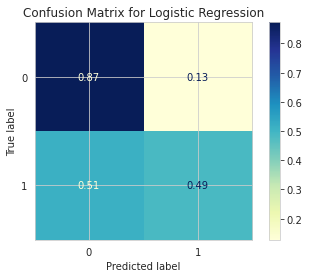

In [117]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Logistic Regression')
plt.show(matrix)

In [118]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7299270072992701
Precision = 0.7244147181987258
Recall = 0.6802893837806236
f1-Score = 0.7173459982757199


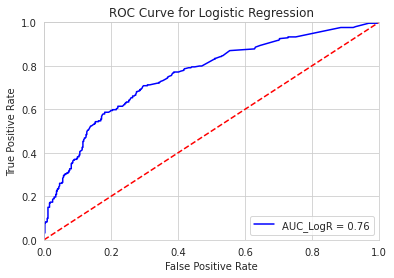

In [119]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_LogR, tpr_LogR, threshold = roc_curve(Y_Test, Probs)
roc_auc_LogR = auc(fpr_LogR, tpr_LogR)
#
plt.title('ROC Curve for Logistic Regression')
plt.plot(fpr_LogR, tpr_LogR, 'b', label = 'AUC_LogR = %0.2f' % roc_auc_LogR)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### K-Nearest Neighbour (KNN) Classifier

In [121]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors= 19)
neigh = neigh.fit(X_Train, Y_Train)
Preds = neigh.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = neigh.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.306569
Score for Willingness: 0.709018


In [122]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[374,  57],
       [153, 101]])

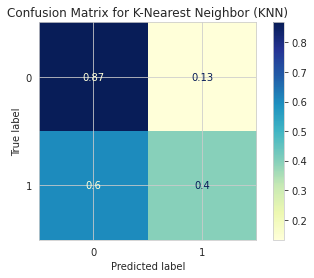

In [123]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(neigh, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for K-Nearest Neighbor (KNN)')
plt.show(matrix)

In [124]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.6934306569343066
Precision = 0.6835592063496795
Recall = 0.6326936076145935
f1-Score = 0.6730743083950114


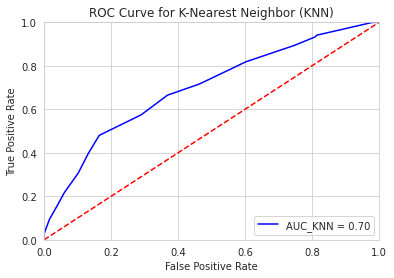

In [125]:
Probs = neigh.predict_proba(X_Test)[:,1]
fpr_KNN, tpr_KNN, threshold = roc_curve(Y_Test, Probs)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
#
plt.title('ROC Curve for K-Nearest Neighbor (KNN)')
plt.plot(fpr_KNN, tpr_KNN, 'b', label = 'AUC_KNN = %0.2f' % roc_auc_KNN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Support Vector Machine (SVM) Classifier(s) - SVCs

In [128]:
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability= True))
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.277372
Score for Willingness: 0.748083


In [129]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[352,  79],
       [111, 143]])

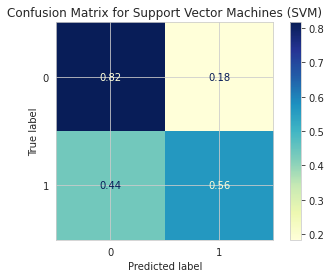

In [130]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Support Vector Machines (SVM)')
plt.show(matrix)

In [131]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7226277372262774
Precision = 0.7172033852206008
Recall = 0.689848731205583
f1-Score = 0.7182684566502836


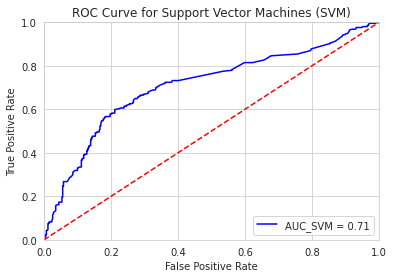

In [132]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_SVM, tpr_SVM, threshold = roc_curve(Y_Test, Probs)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)
#
plt.title('ROC Curve for Support Vector Machines (SVM)')
plt.plot(fpr_SVM, tpr_SVM, 'b', label = 'AUC_SVM = %0.2f' % roc_auc_SVM)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Stochastic Gradient Descent (SGD) Classifier

In [133]:
from sklearn.linear_model import SGDClassifier
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, loss='log'))
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.278832
Score for Willingness: 0.709383


In [134]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[373,  58],
       [133, 121]])

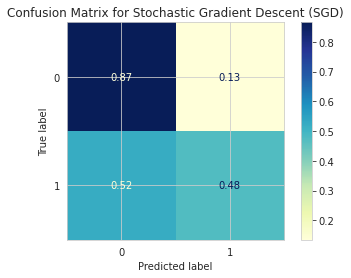

In [135]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Stochastic Gradient Descent (SGD)')
plt.show(matrix)

In [136]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7211678832116788
Precision = 0.7144697266533201
Recall = 0.6709035935473263
f1-Score = 0.7081788414630404


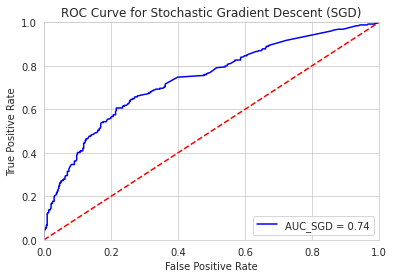

In [137]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_SGD, tpr_SGD, threshold = roc_curve(Y_Test, Probs)
roc_auc_SGD = auc(fpr_SGD, tpr_SGD)
#
plt.title('ROC Curve for Stochastic Gradient Descent (SGD)')
plt.plot(fpr_SGD, tpr_SGD, 'b', label = 'AUC_SGD = %0.2f' % roc_auc_SGD)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Decision Tree Classifier

In [138]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.347445
Score for Willingness: 0.809419


In [139]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[358,  73],
       [165,  89]])

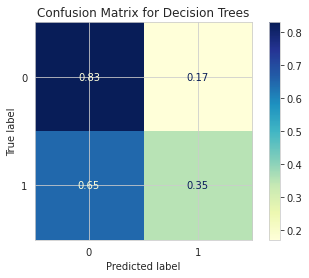

In [140]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Decision Trees')
plt.show(matrix)

In [141]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.6525547445255474
Precision = 0.6344059364570825
Recall = 0.5905100754517054
f1-Score = 0.630888442763529


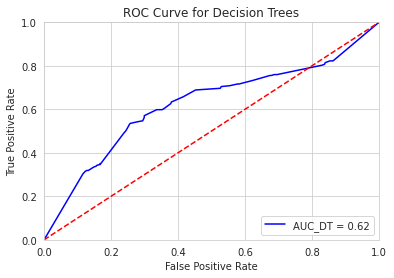

In [142]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_DT, tpr_DT, threshold = roc_curve(Y_Test, Probs)
roc_auc_DT = auc(fpr_DT, tpr_DT)
#
plt.title('ROC Curve for Decision Trees')
plt.plot(fpr_DT, tpr_DT, 'b', label = 'AUC_DT = %0.2f' % roc_auc_DT)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### GradBoost Classifier

In [143]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.283212
Score for Willingness: 0.730194


In [144]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[358,  73],
       [121, 133]])

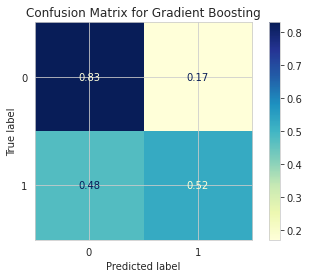

In [145]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show(matrix)

In [146]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7167883211678832
Precision = 0.7096577404707591
Recall = 0.6771242486800519
f1-Score = 0.7094813786657648


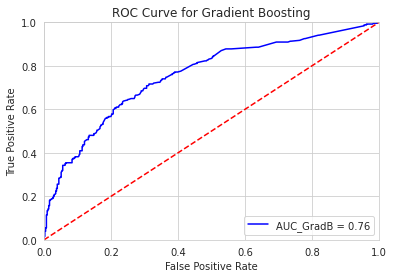

In [147]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_GradB, tpr_GradB, threshold = roc_curve(Y_Test, Probs)
roc_auc_GradB = auc(fpr_GradB, tpr_GradB)
#
plt.title('ROC Curve for Gradient Boosting')
plt.plot(fpr_GradB, tpr_GradB, 'b', label = 'AUC_GradB = %0.2f' % roc_auc_GradB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Random Forest Classifier

In [148]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.329927
Score for Willingness: 0.809419


In [149]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[343,  88],
       [138, 116]])

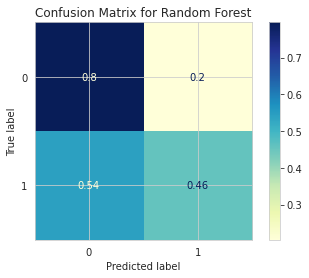

In [150]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Random Forest')
plt.show(matrix)

In [151]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.67007299270073
Precision = 0.6595277180936262
Recall = 0.6262582896395491
f1-Score = 0.6611079283169515


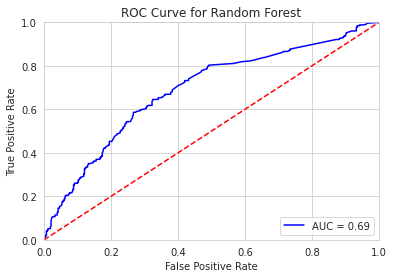

In [152]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_RF, tpr_RF, threshold = roc_curve(Y_Test, Probs)
roc_auc_RF = auc(fpr_RF, tpr_RF)
#
plt.title('ROC Curve for Random Forest')
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC = %0.2f' % roc_auc_RF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Extra-Trees Classifier

In [154]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.341606
Score for Willingness: 0.809419


In [155]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[355,  76],
       [158,  96]])

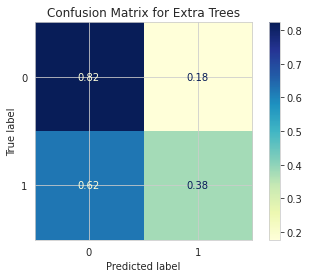

In [156]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Extra Trees')
plt.show(matrix)

In [157]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.6583941605839416
Precision = 0.6423690547215282
Recall = 0.6008093245884867
f1-Score = 0.6403532975659225


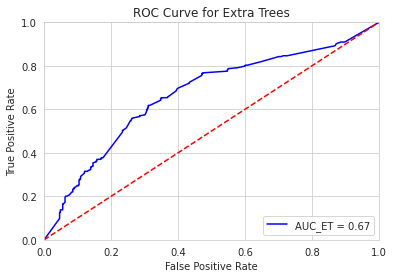

In [158]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_ET, tpr_ET, threshold = roc_curve(Y_Test, Probs)
roc_auc_ET = auc(fpr_ET, tpr_ET)
#
plt.title('ROC Curve for Extra Trees')
plt.plot(fpr_ET, tpr_ET, 'b', label = 'AUC_ET = %0.2f' % roc_auc_ET)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### AdaBoost Classifier

In [159]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.277372
Score for Willingness: 0.717780


In [160]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[376,  55],
       [135, 119]])

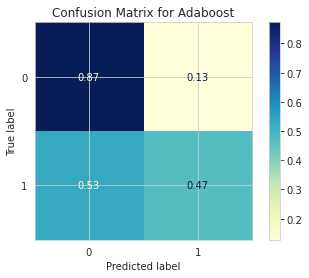

In [161]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Adaboost')
plt.show(matrix)

In [162]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7226277372262774
Precision = 0.7165659460326546
Recall = 0.6704468640955843
f1-Score = 0.70848311124996


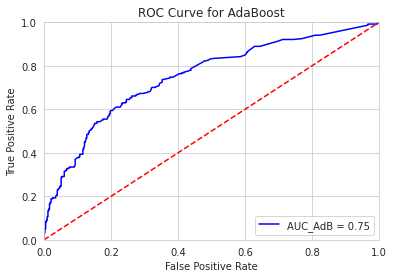

In [163]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_AdB, tpr_AdB, threshold = roc_curve(Y_Test, Probs)
roc_auc_AdB = auc(fpr_AdB, tpr_AdB)
#
plt.title('ROC Curve for AdaBoost')
plt.plot(fpr_AdB, tpr_AdB, 'b', label = 'AUC_AdB = %0.2f' % roc_auc_AdB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### XgBoost Classifier

In [164]:
import xgboost as xgb
clf = xgb.XGBClassifier(objective='reg:tweedie')
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.281752
Score for Willingness: 0.726177


In [165]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[377,  54],
       [139, 115]])

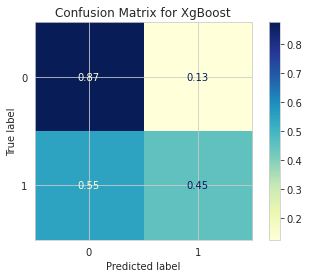

In [166]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for XgBoost')
plt.show(matrix)

In [167]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7182481751824817
Precision = 0.7120255817636437
Recall = 0.6637329411549775
f1-Score = 0.702584393977966


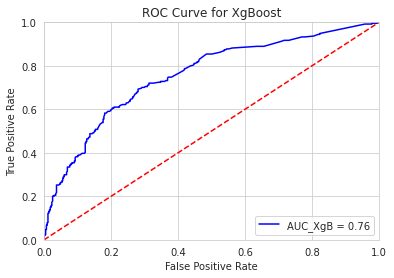

In [168]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_XgB, tpr_XgB, threshold = roc_curve(Y_Test, Probs)
roc_auc_XgB = auc(fpr_XgB, tpr_XgB)
#
plt.title('ROC Curve for XgBoost')
plt.plot(fpr_XgB, tpr_XgB, 'b', label = 'AUC_XgB = %0.2f' % roc_auc_XgB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Multi-Layer Perceptron (MLP) Classifier

In [169]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=1000)
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.315328
Score for Willingness: 0.778021


In [170]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[344,  87],
       [129, 125]])

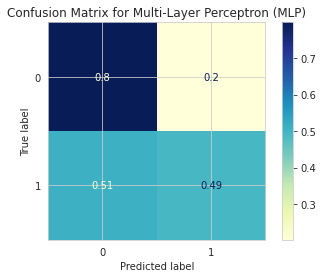

In [171]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Multi-Layer Perceptron (MLP)')
plt.show(matrix)

In [172]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.6846715328467153
Precision = 0.6762316735736376
Recall = 0.6451349178800445
f1-Score = 0.6777865599060513


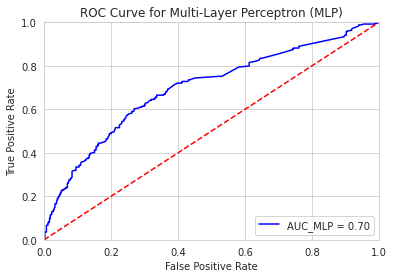

In [173]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_MLP, tpr_MLP, threshold = roc_curve(Y_Test, Probs)
roc_auc_MLP = auc(fpr_MLP, tpr_MLP)
#
plt.title('ROC Curve for Multi-Layer Perceptron (MLP)')
plt.plot(fpr_MLP, tpr_MLP, 'b', label = 'AUC_MLP = %0.2f' % roc_auc_MLP)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Combined ROC Plot(s)

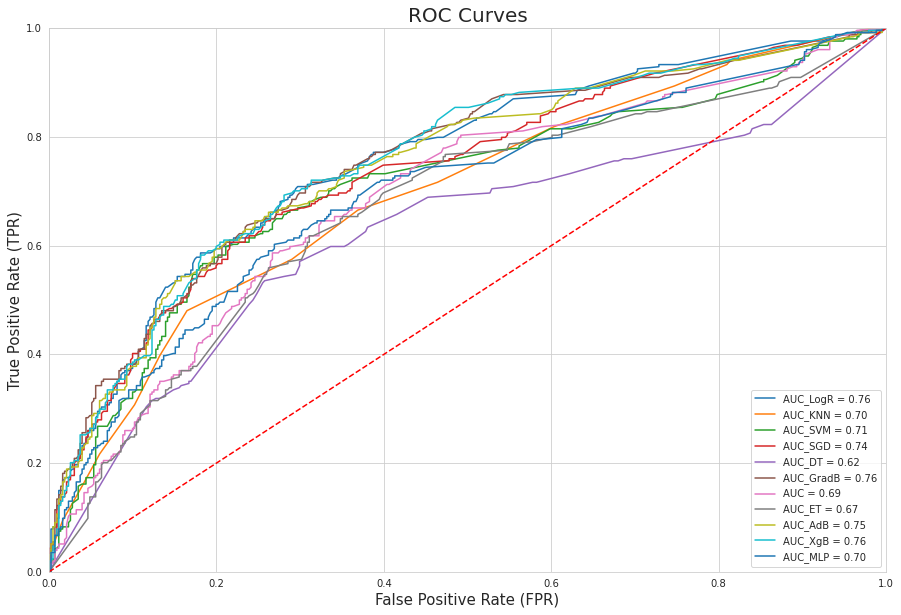

In [174]:
plt.figure(figsize = (15,10))
plt.title('ROC Curves', fontsize = 20)
plt.plot(fpr_LogR, tpr_LogR, label = 'AUC_LogR = %0.2f' % roc_auc_LogR)
plt.plot(fpr_KNN, tpr_KNN, label = 'AUC_KNN = %0.2f' % roc_auc_KNN)
plt.plot(fpr_SVM, tpr_SVM, label = 'AUC_SVM = %0.2f' % roc_auc_SVM)
plt.plot(fpr_SGD, tpr_SGD, label = 'AUC_SGD = %0.2f' % roc_auc_SGD)
plt.plot(fpr_DT, tpr_DT, label = 'AUC_DT = %0.2f' % roc_auc_DT)
plt.plot(fpr_GradB, tpr_GradB, label = 'AUC_GradB = %0.2f' % roc_auc_GradB)
plt.plot(fpr_RF, tpr_RF, label = 'AUC = %0.2f' % roc_auc_RF)
plt.plot(fpr_ET, tpr_ET, label = 'AUC_ET = %0.2f' % roc_auc_ET)
plt.plot(fpr_AdB, tpr_AdB, label = 'AUC_AdB = %0.2f' % roc_auc_AdB)
plt.plot(fpr_XgB, tpr_XgB, label = 'AUC_XgB = %0.2f' % roc_auc_XgB)
plt.plot(fpr_MLP, tpr_MLP, label = 'AUC_MLP = %0.2f' % roc_auc_MLP)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)', fontsize = 15)
plt.xlabel('False Positive Rate (FPR)', fontsize = 15)
plt.show()

### Machine Learning on Autoencoder-Based Feature Representations
Feature extraction was performed using an autoencoder to obtain a lower-dimensional representation of the original dataset, capturing the most informative patterns while minimizing redundancy. This compressed feature set was then used as input for machine learning models to assess its predictive capability. Logistic Regression was applied as a baseline classifier on the transformed features to evaluate whether the reduced representation could achieve comparable or improved performance relative to models trained on the full feature set. This approach not only aids in dimensionality reduction but also serves as a robustness check for the effectiveness of the autoencoder in preserving essential data characteristics.


### Logistic Regression based Classifier

In [192]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error: %f" % MAE)
print("Score: %f" % Score)

Mean Absolute Error: 0.204380
Score: 0.854691


In [193]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[367,  64],
       [ 76, 178]])

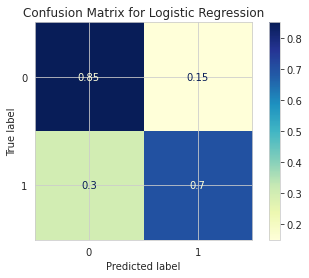

In [194]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Logistic Regression')
plt.show(matrix)

In [195]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7956204379562044
Precision = 0.7939929007677559
Recall = 0.7761477611122276
f1-Score = 0.794551167899376


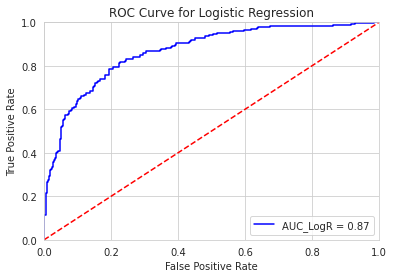

In [196]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_LogR, tpr_LogR, threshold = roc_curve(Y_Test, Probs)
roc_auc_LogR = auc(fpr_LogR, tpr_LogR)
#
plt.title('ROC Curve for Logistic Regression')
plt.plot(fpr_LogR, tpr_LogR, 'b', label = 'AUC_LogR = %0.2f' % roc_auc_LogR)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### K-Nearest Neighbour (KNN) 

In [198]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors= 7)
neigh = neigh.fit(X_Train, Y_Train)
Preds = neigh.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = neigh.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.207299
Score for Willingness: 0.871851


In [199]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[354,  77],
       [ 65, 189]])

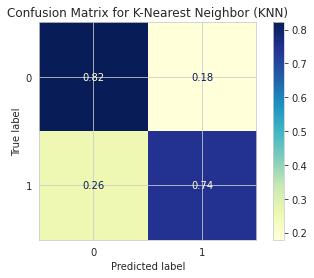

In [200]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(neigh, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for K-Nearest Neighbor (KNN)')
plt.show(matrix)

In [201]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7927007299270074
Precision = 0.7950541737686551
Recall = 0.7827200979227944
f1-Score = 0.7936293556164746


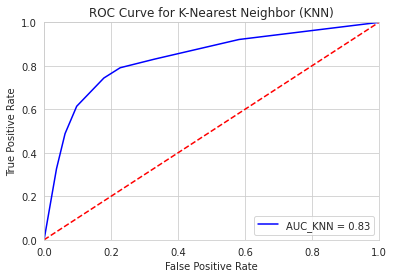

In [202]:
Probs = neigh.predict_proba(X_Test)[:,1]
fpr_KNN, tpr_KNN, threshold = roc_curve(Y_Test, Probs)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
#
plt.title('ROC Curve for K-Nearest Neighbor (KNN)')
plt.plot(fpr_KNN, tpr_KNN, 'b', label = 'AUC_KNN = %0.2f' % roc_auc_KNN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Support Vector Machine (SVM) Classifier(s) - SVCs

In [205]:
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability= True))
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.197080
Score for Willingness: 0.858708


In [206]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[365,  66],
       [ 69, 185]])

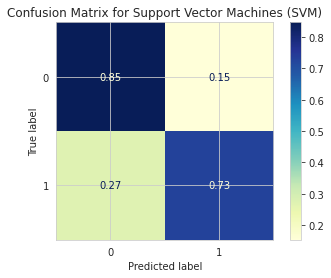

In [207]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Support Vector Machines (SVM)')
plt.show(matrix)

In [208]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.8029197080291971
Precision = 0.8024643998596083
Recall = 0.7876071030564336
f1-Score = 0.8026760787550844


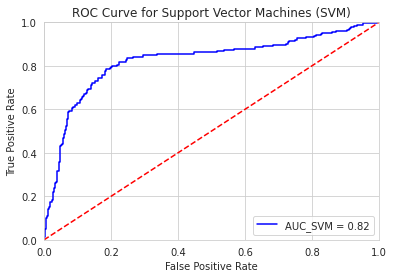

In [209]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_SVM, tpr_SVM, threshold = roc_curve(Y_Test, Probs)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)
#
plt.title('ROC Curve for Support Vector Machines (SVM)')
plt.plot(fpr_SVM, tpr_SVM, 'b', label = 'AUC_SVM = %0.2f' % roc_auc_SVM)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Stochastic Gradient Descent (SGD) Classifier

In [210]:
from sklearn.linear_model import SGDClassifier
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, loss='log'))
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.210219
Score for Willingness: 0.838627


In [211]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[341,  90],
       [ 54, 200]])

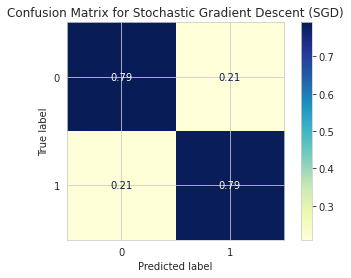

In [212]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Stochastic Gradient Descent (SGD)')
plt.show(matrix)

In [213]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7897810218978102
Precision = 0.7989064157748347
Recall = 0.7892924347333614
f1-Score = 0.7921557538022015


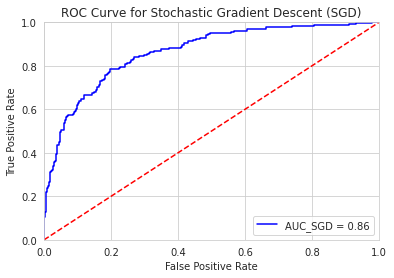

In [214]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_SGD, tpr_SGD, threshold = roc_curve(Y_Test, Probs)
roc_auc_SGD = auc(fpr_SGD, tpr_SGD)
#
plt.title('ROC Curve for Stochastic Gradient Descent (SGD)')
plt.plot(fpr_SGD, tpr_SGD, 'b', label = 'AUC_SGD = %0.2f' % roc_auc_SGD)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision Tree Classifier

In [215]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.252555
Score for Willingness: 1.000000


In [216]:
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[338,  93],
       [ 80, 174]])

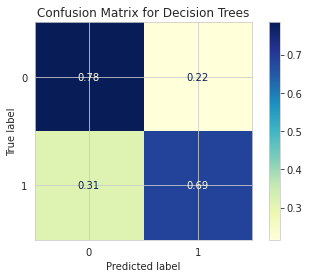

In [217]:
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Decision Trees')
plt.show(matrix)

In [218]:
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7474452554744525
Precision = 0.7504234330074868
Recall = 0.7346310539488828
f1-Score = 0.7486625546235667


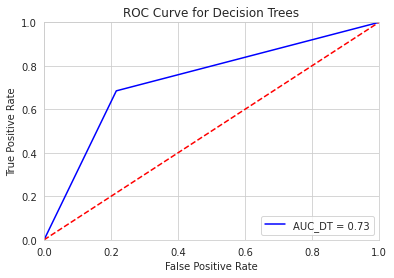

In [219]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_DT, tpr_DT, threshold = roc_curve(Y_Test, Probs)
roc_auc_DT = auc(fpr_DT, tpr_DT)
#
plt.title('ROC Curve for Decision Trees')
plt.plot(fpr_DT, tpr_DT, 'b', label = 'AUC_DT = %0.2f' % roc_auc_DT)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### GradBoost Classifier

In [220]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.197080
Score for Willingness: 0.884264


In [221]:
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

confusion_matrix(Y_Test, Predictions)

array([[364,  67],
       [ 68, 186]])

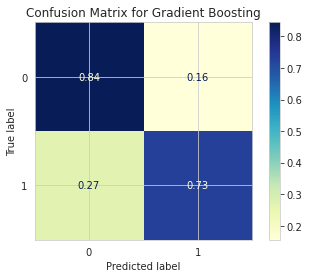

In [222]:
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show(matrix)

In [223]:
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.8029197080291971
Precision = 0.8027628982087883
Recall = 0.7884155141860167
f1-Score = 0.8028395320183299


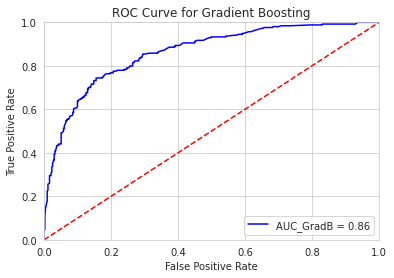

In [224]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_GradB, tpr_GradB, threshold = roc_curve(Y_Test, Probs)
roc_auc_GradB = auc(fpr_GradB, tpr_GradB)

plt.title('ROC Curve for Gradient Boosting')
plt.plot(fpr_GradB, tpr_GradB, 'b', label = 'AUC_GradB = %0.2f' % roc_auc_GradB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Random Forest Classifier

In [225]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.220438
Score for Willingness: 1.000000


In [226]:
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

confusion_matrix(Y_Test, Predictions)

array([[355,  76],
       [ 75, 179]])

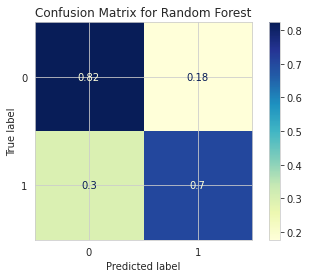

In [227]:
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Random Forest')
plt.show(matrix)

In [228]:
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7795620437956204
Precision = 0.7797425118409271
Recall = 0.7641951513601403
f1-Score = 0.7796505712772391


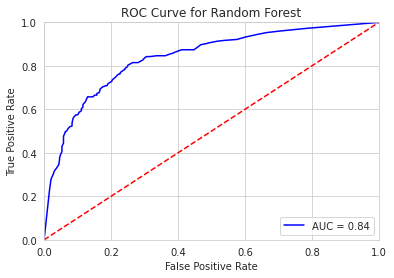

In [229]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_RF, tpr_RF, threshold = roc_curve(Y_Test, Probs)
roc_auc_RF = auc(fpr_RF, tpr_RF)
#
plt.title('ROC Curve for Random Forest')
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC = %0.2f' % roc_auc_RF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Extra-Trees Classifier

In [231]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.227737
Score for Willingness: 1.000000


In [232]:
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

confusion_matrix(Y_Test, Predictions)

array([[359,  72],
       [ 84, 170]])

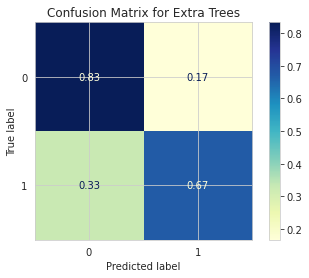

In [233]:
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Extra Trees')
plt.show(matrix)

In [234]:
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7722627737226277
Precision = 0.7703724775182128
Recall = 0.7511189871567678
f1-Score = 0.7710713013735904


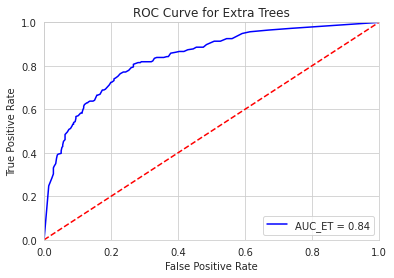

In [235]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_ET, tpr_ET, threshold = roc_curve(Y_Test, Probs)
roc_auc_ET = auc(fpr_ET, tpr_ET)

plt.title('ROC Curve for Extra Trees')
plt.plot(fpr_ET, tpr_ET, 'b', label = 'AUC_ET = %0.2f' % roc_auc_ET)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### AdaBoost Classifier

In [236]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.208759
Score for Willingness: 0.865279


In [237]:
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

confusion_matrix(Y_Test, Predictions)

array([[354,  77],
       [ 66, 188]])

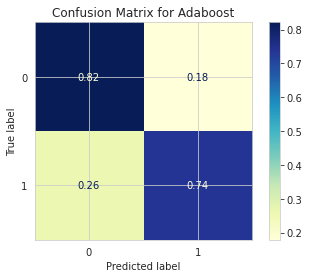

In [238]:
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Adaboost')
plt.show(matrix)

In [239]:
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7912408759124088
Precision = 0.7933834379365298
Recall = 0.7807515939857865
f1-Score = 0.7921039524710624


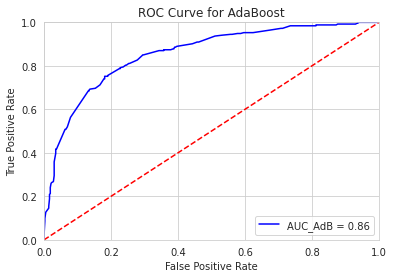

In [240]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_AdB, tpr_AdB, threshold = roc_curve(Y_Test, Probs)
roc_auc_AdB = auc(fpr_AdB, tpr_AdB)

plt.title('ROC Curve for AdaBoost')
plt.plot(fpr_AdB, tpr_AdB, 'b', label = 'AUC_AdB = %0.2f' % roc_auc_AdB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### XgBoost Classifier

In [241]:
import xgboost as xgb
clf = xgb.XGBClassifier(objective='reg:tweedie')
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.198540
Score for Willingness: 0.873311


In [242]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[365,  66],
       [ 70, 184]])

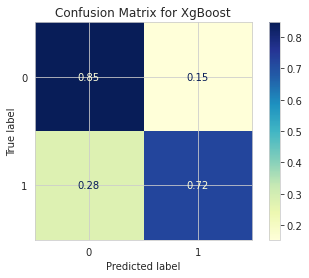

In [243]:
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for XgBoost')
plt.show(matrix)

In [244]:
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.8014598540145985
Precision = 0.8008579243225102
Recall = 0.7856385991194257
f1-Score = 0.8011305185695367


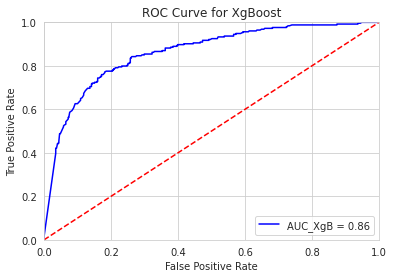

In [245]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_XgB, tpr_XgB, threshold = roc_curve(Y_Test, Probs)
roc_auc_XgB = auc(fpr_XgB, tpr_XgB)

plt.title('ROC Curve for XgBoost')
plt.plot(fpr_XgB, tpr_XgB, 'b', label = 'AUC_XgB = %0.2f' % roc_auc_XgB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Multi-Layer Perceptron (MLP) Classifier

In [246]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=1000)
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error for Classification: %f" % MAE)
print("Score for Willingness: %f" % Score)

Mean Absolute Error for Classification: 0.211679
Score for Willingness: 0.851041


In [247]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[368,  63],
       [ 82, 172]])

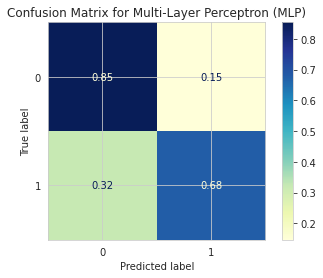

In [248]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, cmap= 'YlGnBu', normalize= 'true')
plt.title('Confusion Matrix for Multi-Layer Perceptron (MLP)')
plt.show(matrix)

In [249]:
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7883211678832117
Precision = 0.7859395696364171
Recall = 0.7654968302976048
f1-Score = 0.7864913733088111


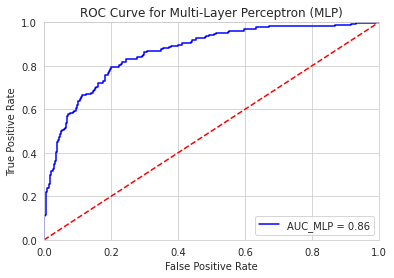

In [250]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_MLP, tpr_MLP, threshold = roc_curve(Y_Test, Probs)
roc_auc_MLP = auc(fpr_MLP, tpr_MLP)
#
plt.title('ROC Curve for Multi-Layer Perceptron (MLP)')
plt.plot(fpr_MLP, tpr_MLP, 'b', label = 'AUC_MLP = %0.2f' % roc_auc_MLP)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Combined ROC Plot(s)

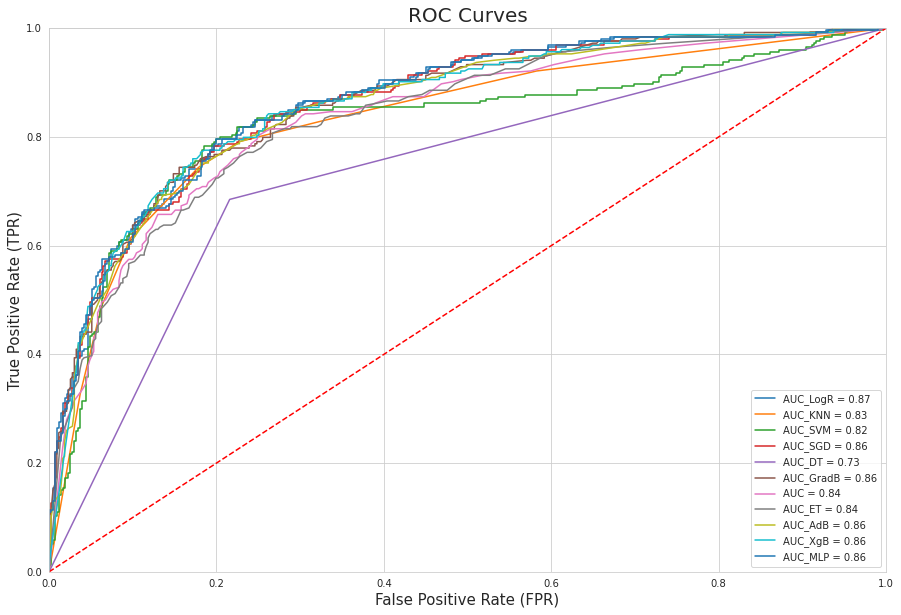

In [251]:
plt.figure(figsize = (15,10))
plt.title('ROC Curves', fontsize = 20)
plt.plot(fpr_LogR, tpr_LogR, label = 'AUC_LogR = %0.2f' % roc_auc_LogR)
plt.plot(fpr_KNN, tpr_KNN, label = 'AUC_KNN = %0.2f' % roc_auc_KNN)
plt.plot(fpr_SVM, tpr_SVM, label = 'AUC_SVM = %0.2f' % roc_auc_SVM)
plt.plot(fpr_SGD, tpr_SGD, label = 'AUC_SGD = %0.2f' % roc_auc_SGD)
plt.plot(fpr_DT, tpr_DT, label = 'AUC_DT = %0.2f' % roc_auc_DT)
plt.plot(fpr_GradB, tpr_GradB, label = 'AUC_GradB = %0.2f' % roc_auc_GradB)
plt.plot(fpr_RF, tpr_RF, label = 'AUC = %0.2f' % roc_auc_RF)
plt.plot(fpr_ET, tpr_ET, label = 'AUC_ET = %0.2f' % roc_auc_ET)
plt.plot(fpr_AdB, tpr_AdB, label = 'AUC_AdB = %0.2f' % roc_auc_AdB)
plt.plot(fpr_XgB, tpr_XgB, label = 'AUC_XgB = %0.2f' % roc_auc_XgB)
plt.plot(fpr_MLP, tpr_MLP, label = 'AUC_MLP = %0.2f' % roc_auc_MLP)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)', fontsize = 15)
plt.xlabel('False Positive Rate (FPR)', fontsize = 15)
plt.show()

##### KERAS Built Custom ANN

In [253]:
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import seed

model = Sequential()
model.add(Dense(24, input_dim=2, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_Train, Y_Train, epochs=150, batch_size=10,shuffle=True)
Y_pred = model.predict_classes(X_Test, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                72        
_________________________________________________________________
dense_5 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
274/274 [==============================] - 1s 2ms/step - loss: 0.4744 - accuracy: 0.7750
Epoch 2/150
274/274 [==============================] - 1s 2ms/step - loss: 0.4217 - accuracy: 0.8119
Epoch 3/150
274/274 [==============================] - 1s 2ms/step - loss: 0.3845 - accuracy: 0.8283
Epoch 4/150
274/274 [==============================] - 1s 2ms/step - loss: 0.3880 -

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [254]:
from sklearn.metrics import classification_report
print(classification_report(Y_Test, Y_pred))

_, accuracy = model.evaluate(X_Train, Y_Train)
print('Accuracy: %.2f' % (accuracy*100))

_, test_acc = model.evaluate(X_Test, Y_Test, verbose=0)
print('Accuracy: %.2f' % (test_acc*100))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       431
           1       0.71      0.76      0.73       254

    accuracy                           0.80       685
   macro avg       0.78      0.79      0.79       685
weighted avg       0.80      0.80      0.80       685

86/86 [==============================] - 0s 1ms/step - loss: 0.3490 - accuracy: 0.8540
Accuracy: 85.40
Accuracy: 79.71


## Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,min_samples_leaf=2,min_samples_split=3)
clf = clf.fit(X_Train, Y_Train)
Preds = clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error is: %f" % MAE)


Mean Absolute Error is: 0.197080


In [11]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[383,  48],
       [ 87, 167]])

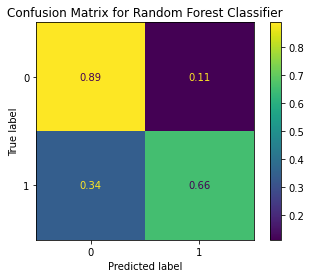

In [12]:
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, normalize= 'true')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show(matrix)

In [13]:
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.8029197080291971
Precision = 0.8007476966306338
Recall = 0.7730557027239344
f1-Score = 0.7989908718401675


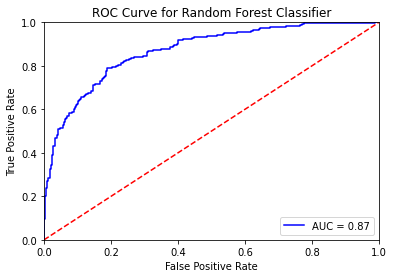

In [14]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_RF, tpr_RF, threshold = roc_curve(Y_Test, Probs)
roc_auc_RF = auc(fpr_RF, tpr_RF)
#
plt.title('ROC Curve for Random Forest Classifier')
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC = %0.2f' % roc_auc_RF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## BaggingClassifier

In [15]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(n_estimators=10, random_state=0)
clf = clf.fit(X_Train, Y_Train)
Preds=clf.predict(X_Test)
MAE = mean_absolute_error(Y_Test, Preds)
Score = clf.score(X_Train, Y_Train)
print("Mean Absolute Error is: %f" % MAE)


Mean Absolute Error is: 0.220438


In [16]:
# Round Predictions
Predictions = np.zeros(len(Preds))
for i in range(0,len(Preds)):
  Predictions[i] = round(Preds[i])

# Generate Confusion Matrix
confusion_matrix(Y_Test, Predictions)

array([[370,  61],
       [ 90, 164]])

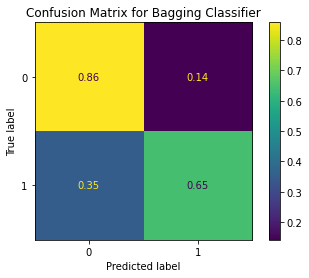

In [17]:
# Plot Normalized Confusion Matrix
matrix = plot_confusion_matrix(clf, X_Test, Y_Test, normalize= 'true')
plt.title('Confusion Matrix for Bagging Classifier')
plt.show(matrix)

In [18]:
# Evaluating Parameters
Accuracy = accuracy_score(Y_Test, Predictions)
print(f'Accuracy = {Accuracy}')
Precision = precision_score(Y_Test, Predictions, average= 'weighted')
print(f'Precision = {Precision}')
Recall = recall_score(Y_Test, Predictions, average= 'macro')
print(f'Recall = {Recall}')
f1_Score = f1_score(Y_Test, Predictions, average= 'weighted')
print(f'f1-Score = {f1_Score}')

Accuracy = 0.7795620437956204
Precision = 0.7763674318558481
Recall = 0.752068984416391
f1-Score = 0.7764764526712827


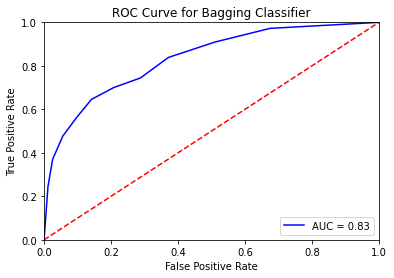

In [19]:
Probs= clf.predict_proba(X_Test)[:,1]
fpr_RF, tpr_RF, threshold = roc_curve(Y_Test, Probs)
roc_auc_RF = auc(fpr_RF, tpr_RF)
#
plt.title('ROC Curve for Bagging Classifier')
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC = %0.2f' % roc_auc_RF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural Network 


In [20]:
model = Sequential()
model.add(Dense(24, input_dim=119, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                2880      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 3,193
Trainable params: 3,193
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.fit(X_Train, Y_Train, epochs=150, batch_size=10,shuffle=True)

Epoch 1/150
274/274 [==============================] - 1s 2ms/step - loss: 17.7387 - accuracy: 0.5357
Epoch 2/150
274/274 [==============================] - 1s 2ms/step - loss: 0.5872 - accuracy: 0.7335
Epoch 3/150
274/274 [==============================] - 1s 2ms/step - loss: 0.5792 - accuracy: 0.7434
Epoch 4/150
274/274 [==============================] - 1s 2ms/step - loss: 0.5994 - accuracy: 0.7369
Epoch 5/150
274/274 [==============================] - 1s 2ms/step - loss: 0.5698 - accuracy: 0.7654
Epoch 6/150
274/274 [==============================] - 1s 2ms/step - loss: 0.5297 - accuracy: 0.7644
Epoch 7/150
274/274 [==============================] - 1s 2ms/step - loss: 0.5541 - accuracy: 0.7722
Epoch 8/150
274/274 [==============================] - 1s 2ms/step - loss: 0.5422 - accuracy: 0.7636
Epoch 9/150
274/274 [==============================] - 1s 2ms/step - loss: 0.4899 - accuracy: 0.7889
Epoch 10/150
274/274 [==============================] - 1s 2ms/step - loss: 0.4676 - accur

In [24]:
Y_pred = model.predict_classes(X_Test, verbose=0)
Probs= model.predict_proba(X_Test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


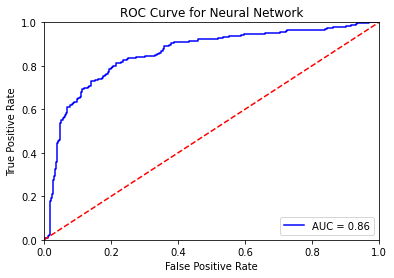

In [25]:

fpr_RF, tpr_RF, threshold = roc_curve(Y_Test, Probs)
roc_auc_RF = auc(fpr_RF, tpr_RF)
#
plt.title('ROC Curve for Neural Network')
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC = %0.2f' % roc_auc_RF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [26]:

print(classification_report(Y_Test, Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       431
           1       0.76      0.70      0.73       254

    accuracy                           0.81       685
   macro avg       0.79      0.79      0.79       685
weighted avg       0.80      0.81      0.80       685



In [27]:
_, accuracy = model.evaluate(X_Train, Y_Train)
print('Accuracy: %.2f' % (accuracy*100))

86/86 [==============================] - 0s 2ms/step - loss: 0.3341 - accuracy: 0.8518
Accuracy: 85.18


In [28]:

_, test_acc = model.evaluate(X_Test, Y_Test, verbose=0)
print('Accuracy: %.2f' % (test_acc*100))

Accuracy: 80.58
